In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

from ionpy.analysis import ResultsLoader
from ese.experiment.experiment import CalibrationExperiment
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE"

%load_ext yamlmagic
%load_ext autoreload
%autoreload 2

In [2]:
path = f"{root}/WMH_aug_runs"

dfc = rs.load_configs(
    path,
    properties=False,
)

df = rs.load_metrics(dfc)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [3]:

os.environ["CUDA_VISIBLE_DEVICES"] = '1'

best_exp = rs.get_best_experiment(
    df=df,
    exp_class=CalibrationExperiment,
    device="cuda"
)
best_exp.build_dataloader()

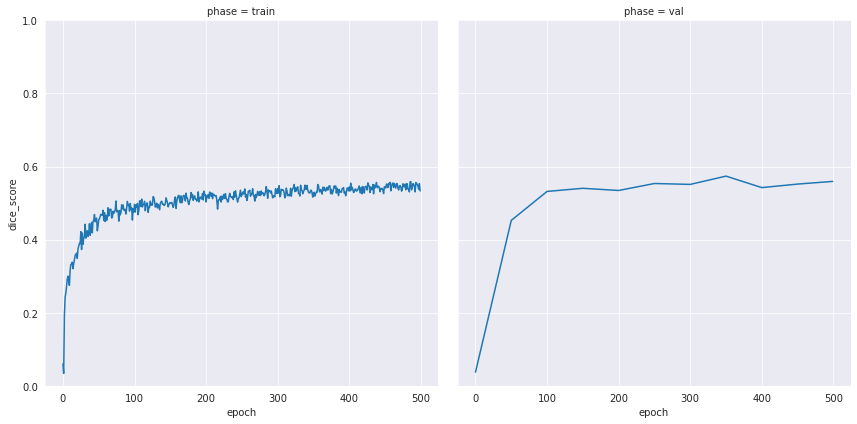

In [4]:
best_exp.vis_loss_curves(height=6)

In [5]:
from ese.experiment.analysis.inference import get_dataset_perf 

# val_perf is a dict where each item is the subj id
predictions_list = get_dataset_perf(
    exp=best_exp, 
    split="val"
    )

  0%|          | 0/15 [00:00<?, ?it/s]

In [6]:
from ese.experiment.analysis.inference import get_pixelinfo_df

pixel_preds_df = get_pixelinfo_df(
    data_points=predictions_list,
    num_bins=10,
    num_labels=2
    )

  0%|          | 0/15 [00:00<?, ?it/s]

(tensor(0.5000), tensor(0.5500))
(tensor(0.5500), tensor(0.6000))
(tensor(0.6000), tensor(0.6500))
(tensor(0.6500), tensor(0.7000))
(tensor(0.7000), tensor(0.7500))
(tensor(0.7500), tensor(0.8000))
(tensor(0.8000), tensor(0.8500))
(tensor(0.8500), tensor(0.9000))
(tensor(0.9000), tensor(0.9500))
(tensor(0.9500), tensor(1.))


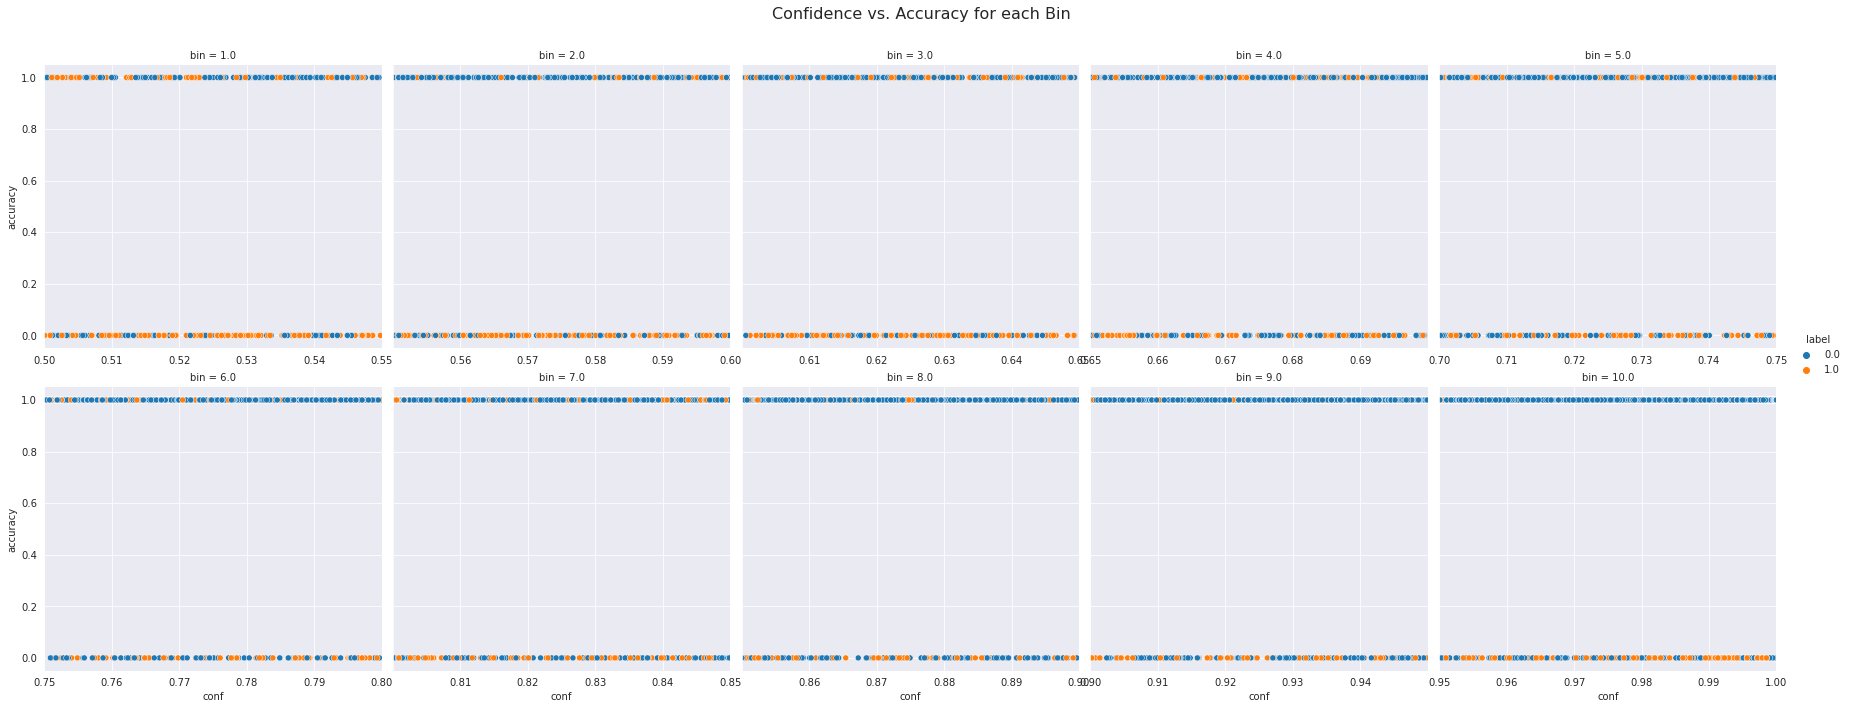

In [12]:
from ese.experiment.metrics.utils.utils import get_bins

# Get the different confidence bins.
bin_starts, conf_bin_widths = get_bins(
    num_bins=10,
    class_type="Multi-class",
    num_labels=2
    )
bin_ends = bin_starts + conf_bin_widths 
bin_edges = {(i+1): (start, end) for i, (start, end) in enumerate(zip(bin_starts, bin_ends))}

# Using relplot to create a FacetGrid of scatter plots
g = sns.relplot(data=pixel_preds_df, 
                x='conf', 
                y='accuracy', 
                hue='label',
                col='bin', 
                col_wrap=5, 
                kind='scatter', 
                height=5,
                facet_kws={'sharex': False})
# Adjusting the titles
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Confidence vs. Accuracy for each Bin', fontsize=16)

# Adjust x-axis limits for each subplot based on bin edges
for ax, bin_number in zip(g.axes.flat, bin_edges.keys()):
    ax.set_xlim(*bin_edges[bin_number])

plt.show()